In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
#!pip install seaborn
import seaborn as sns
!pip install sweetviz
import sweetviz as sv
import plotly.express as px

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.1 MB 2.9 MB/s 


# <font color=blue size=10> Telco Customer Churn</font>

# <b><font color=BLUE size=12> Evasão de Clientes da Telco</b>

***
**Author**: [Camila Maestrelli](https://www.linkedin.com/in/camila-maestrelli-leobons/)
***

## <b><font color=green> Etapas do Projeto:


### 1. Definição do Problema
### 2. Importação dos dados
### 3. Entendimento dos dados
### 4. Limpeza dos dados

### 5. Análise Exploratória dos Dados
##<b><font color=green> `6. Pré-processamento`

##<b><font color=green> `7. Algoritmo e criação do modelo`

##<b><font color=green>  `8. Interpretação do resultado e avaliação do modelo`


Importando os dados

In [1]:
!pip install findspark

In [2]:
import os
os.environ["SPARK_HOME"] = "C:\spark\spark-3.3.0-bin-hadoop2"

In [3]:
import findspark
findspark.init()

In [4]:
#!pip install pyspark

In [5]:
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.builder.master('local[*]').appName("Classificação com Spark").getOrCreate()

In [7]:
spark

In [8]:
url = 'https://raw.githubusercontent.com/camilamaestrelli/Telco-Customer-Churn/main/Telco-Customer-Churn_for_model.csv'

In [9]:
from pyspark import SparkFiles
spark.sparkContext.addFile(url)
dados = spark.read.csv(SparkFiles.get("Telco-Customer-Churn_for_model.csv"), header=True, inferSchema= True)
dados

DataFrame[index: int, id_cliente: string, churn: int, genero: string, idoso: int, parceirx: int, dependentes: int, tempo_permanencia: int, multiplas_linhas: string, seguranca_online: string, backup_online: string, protecao_dispositivo: string, suporte_tecnico: string, assinatura_tv: string, assinatura_filmes: string, contrato: string, fatura_digital: string, metodo_pagamento: string, mensalidade: double, cobrancas_total: double, diaria: double]

In [10]:
dados.show()

+-----+----------+-----+---------+-----+--------+-----------+-----------------+----------------+----------------+-------------+--------------------+---------------+-------------+-----------------+--------+--------------+--------------------+-----------+---------------+------+
|index|id_cliente|churn|   genero|idoso|parceirx|dependentes|tempo_permanencia|multiplas_linhas|seguranca_online|backup_online|protecao_dispositivo|suporte_tecnico|assinatura_tv|assinatura_filmes|contrato|fatura_digital|    metodo_pagamento|mensalidade|cobrancas_total|diaria|
+-----+----------+-----+---------+-----+--------+-----------+-----------------+----------------+----------------+-------------+--------------------+---------------+-------------+-----------------+--------+--------------+--------------------+-----------+---------------+------+
|    0|0002-ORFBO|    0| Feminino|    0|       1|          1|                9|             Não|             Não|          Sim|                 Não|            Sim|     

## <font color=green> <b>6. Pré-processamento

### Oversampling

In [11]:
dados.groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1| 1869|
|    0| 5174|
+-----+-----+



In [12]:
from pyspark.sql.functions import col, explode, array, lit

major_df = dados.filter(col("churn") == 0)
minor_df = dados.filter(col("churn") == 1)
ratio = int(round(major_df.count()/minor_df.count(),0))
print("ratio: {}".format(ratio))

ratio: 3


In [13]:
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows
combined_df = major_df.unionAll(oversampled_df)
combined_df.show()

+-----+----------+-----+---------+-----+--------+-----------+-----------------+----------------+----------------+-------------+--------------------+---------------+-------------+-----------------+--------+--------------+--------------------+-----------+---------------+------+
|index|id_cliente|churn|   genero|idoso|parceirx|dependentes|tempo_permanencia|multiplas_linhas|seguranca_online|backup_online|protecao_dispositivo|suporte_tecnico|assinatura_tv|assinatura_filmes|contrato|fatura_digital|    metodo_pagamento|mensalidade|cobrancas_total|diaria|
+-----+----------+-----+---------+-----+--------+-----------+-----------------+----------------+----------------+-------------+--------------------+---------------+-------------+-----------------+--------+--------------+--------------------+-----------+---------------+------+
|    0|0002-ORFBO|    0| Feminino|    0|       1|          1|                9|             Não|             Não|          Sim|                 Não|            Sim|     

In [14]:
combined_df.groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0| 5174|
|    1| 5607|
+-----+-----+



### Criando o pipeline

In [15]:
from pyspark.sql import functions as f
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StandardScaler, StringIndexer, VectorAssembler

In [16]:
colunasNumericas = [
    'tempo_permanencia',
    'mensalidade', 
    'cobrancas_total'
]

stages = []

for coluna in colunasNumericas:

   # VectorAssembler Transformation - Converting column to vector type
   assembler = VectorAssembler(inputCols=[coluna],outputCol=coluna+"_Vect")

   # MinMaxScaler Transformation
   scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol=coluna+"_Scaled")
   stages += [assembler, scaler]


In [17]:
colunasCategoricas = [
    'genero',    
    'seguranca_online',
    'backup_online',
    'protecao_dispositivo',     
    'suporte_tecnico',
    'assinatura_tv',
    'assinatura_filmes',
    'contrato',
    'fatura_digital', 
    'metodo_pagamento'    
]


for coluna in colunasCategoricas:
    stringIndexer = StringIndexer(inputCol = coluna, outputCol = coluna + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[coluna + "classVec"])
    stages += [stringIndexer, encoder]

In [18]:
colunasRestantes = [
    'idoso',
    'parceirx',
    'dependentes',
    ]

features_toAssembler = colunasRestantes + [(coluna + '_Scaled') for coluna in colunasNumericas] + [(coluna + 'classVec') for coluna in colunasCategoricas] 
features_toAssembler

['idoso',
 'parceirx',
 'dependentes',
 'tempo_permanencia_Scaled',
 'mensalidade_Scaled',
 'cobrancas_total_Scaled',
 'generoclassVec',
 'seguranca_onlineclassVec',
 'backup_onlineclassVec',
 'protecao_dispositivoclassVec',
 'suporte_tecnicoclassVec',
 'assinatura_tvclassVec',
 'assinatura_filmesclassVec',
 'contratoclassVec',
 'fatura_digitalclassVec',
 'metodo_pagamentoclassVec']

In [19]:
# retirando as variáveis que não utilizaremos
dataset = combined_df\
    .drop(
        'diaria', 'id_cliente'
    )

dataset.show()

+-----+-----+---------+-----+--------+-----------+-----------------+----------------+----------------+-------------+--------------------+---------------+-------------+-----------------+--------+--------------+--------------------+-----------+---------------+
|index|churn|   genero|idoso|parceirx|dependentes|tempo_permanencia|multiplas_linhas|seguranca_online|backup_online|protecao_dispositivo|suporte_tecnico|assinatura_tv|assinatura_filmes|contrato|fatura_digital|    metodo_pagamento|mensalidade|cobrancas_total|
+-----+-----+---------+-----+--------+-----------+-----------------+----------------+----------------+-------------+--------------------+---------------+-------------+-----------------+--------+--------------+--------------------+-----------+---------------+
|    0|    0| Feminino|    0|       1|          1|                9|             Não|             Não|          Sim|                 Não|            Sim|          Sim|              Não|   Anual|           Sim|              

## <font color=green> <b>7. Algoritmo


In [20]:
dataset = dataset.withColumnRenamed('churn', 'label')

X = dataset.columns
X.remove('label')
X.remove('index')
X


['genero',
 'idoso',
 'parceirx',
 'dependentes',
 'tempo_permanencia',
 'multiplas_linhas',
 'seguranca_online',
 'backup_online',
 'protecao_dispositivo',
 'suporte_tecnico',
 'assinatura_tv',
 'assinatura_filmes',
 'contrato',
 'fatura_digital',
 'metodo_pagamento',
 'mensalidade',
 'cobrancas_total']

In [21]:
dataset = dataset.withColumnRenamed('churn', 'label')

In [24]:
SEED = 2408

In [25]:
treino, teste = dataset.randomSplit([0.7, 0.3], seed=SEED)

In [26]:
treino

DataFrame[index: int, label: int, genero: string, idoso: int, parceirx: int, dependentes: int, tempo_permanencia: int, multiplas_linhas: string, seguranca_online: string, backup_online: string, protecao_dispositivo: string, suporte_tecnico: string, assinatura_tv: string, assinatura_filmes: string, contrato: string, fatura_digital: string, metodo_pagamento: string, mensalidade: double, cobrancas_total: double]

In [27]:
teste

DataFrame[index: int, label: int, genero: string, idoso: int, parceirx: int, dependentes: int, tempo_permanencia: int, multiplas_linhas: string, seguranca_online: string, backup_online: string, protecao_dispositivo: string, suporte_tecnico: string, assinatura_tv: string, assinatura_filmes: string, contrato: string, fatura_digital: string, metodo_pagamento: string, mensalidade: double, cobrancas_total: double]

In [28]:
assembler = VectorAssembler(inputCols=features_toAssembler, outputCol='features')

stages += [assembler]

## Árvore de Decisão

In [29]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [30]:
dtc = DecisionTreeClassifier(seed=SEED)

stages += [dtc]

In [31]:
#Create pipeline and pass all stages
pipeline = Pipeline(stages=stages)


In [32]:
grid = ParamGridBuilder()\
        .addGrid(dtc.maxDepth, [2, 5, 10])\
        .addGrid(dtc.maxBins, [10, 32, 45])\
        .addGrid(dtc.minInstancesPerNode, [5, 10, 15])\
        .addGrid(dtc.impurity, ['entropy', 'gini'])\
        .build()

evaluator = MulticlassClassificationEvaluator()

dtc_cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=5,
    seed=SEED
)

modelo_dtc_cv = dtc_cv.fit(treino)

previsoes_dtc_cv_teste = modelo_dtc_cv.transform(teste)

previsoes_dtc_cv_treino = modelo_dtc_cv.transform(treino)

In [190]:
melhor_modelo_dtc_cv = modelo_dtc_cv.bestModel

print('Melhores parâmetros')
print('='*20)
print('Max Depth: ',melhor_modelo_dtc_cv.stages[-1].getMaxDepth())
print('Max Bins: ', melhor_modelo_dtc_cv.stages[-1].getMaxBins())
print('Min Instances per Node: ', melhor_modelo_dtc_cv.stages[-1].getMinInstancesPerNode())
print('Impurity: ', melhor_modelo_dtc_cv.stages[-1].getImpurity())



Melhores parâmetros
Max Depth:  10
Max Bins:  10
Min Instances per Node:  5
Impurity:  entropy


In [33]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc
%matplotlib inline

def curva_roc(previsoes):
    PredAndLabels           = previsoes.select("probability", "label")
    PredAndLabels_collect   = PredAndLabels.collect()
    PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]

    y_test = [i[1] for i in PredAndLabels_list]
    y_score = [i[0] for i in PredAndLabels_list]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = roc_auc_score(y_test, y_score) # 

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Logistic Regression')
    plt.legend(loc="lower right")
    plt.show()

def calcula_mostra_matriz_confusao(df_transform_modelo, normalize=None):
    y_true = df_transform_modelo.select("label")
    y_true = y_true.toPandas()

    y_pred = df_transform_modelo.select("prediction")
    y_pred = y_pred.toPandas()

    cnf_matrix = confusion_matrix(y_true, y_pred,normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
    display(disp.plot())
    curva_roc(df_transform_modelo)
    return
    
def metricas(df):
    print("Acurácia: %f" % evaluator.evaluate(df, {evaluator.metricName: "accuracy"}))
    print("Precisão: %f" % evaluator.evaluate(df, {evaluator.metricName: "precisionByLabel", evaluator.metricLabel: 1}))
    print("Recall: %f" % evaluator.evaluate(df, {evaluator.metricName: "recallByLabel", evaluator.metricLabel: 1}))
    print("F1: %f" % evaluator.evaluate(df, {evaluator.metricName: "fMeasureByLabel", evaluator.metricLabel: 1}))
    return


Random Forest Classifier - Tuning
Dados de Treino
Matriz de Confusão
----------------------------------------


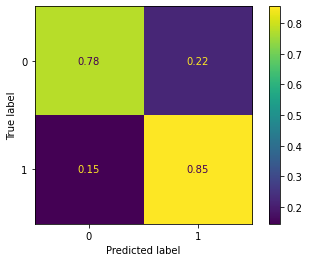

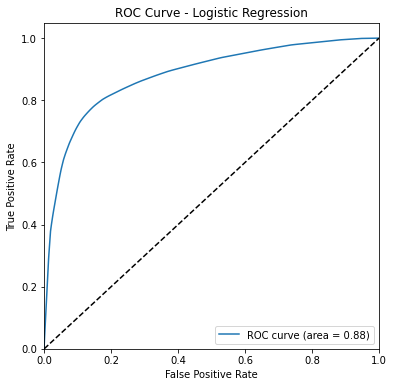

----------------------------------------
Métricas
----------------------------------------
Acurácia: 0.817538
Precisão: 0.803850
Recall: 0.854885
F1: 0.828582

Dados de Teste
Matriz de Confusão
----------------------------------------


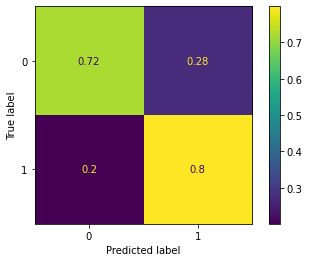

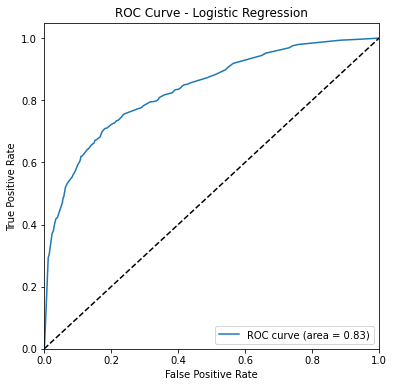

----------------------------------------
Métricas
----------------------------------------
Acurácia: 0.763030
Precisão: 0.764513
Recall: 0.798627
F1: 0.781198


In [34]:
print('Random Forest Classifier - Tuning')
print("="*40)
print("Dados de Treino")
print("="*40)
print("Matriz de Confusão")
print("-"*40)
calcula_mostra_matriz_confusao(previsoes_dtc_cv_treino, normalize='true')
print("-"*40)
print("Métricas")
print("-"*40)

metricas(previsoes_dtc_cv_treino)
print("")
print("="*40)
print("="*40)
print("Dados de Teste")
print("="*40)
print("Matriz de Confusão")
print("-"*40)
calcula_mostra_matriz_confusao(previsoes_dtc_cv_teste, normalize='true')
print("-"*40)
print("Métricas")
print("-"*40)
print("Acurácia: %f" % evaluator.evaluate(previsoes_dtc_cv_teste, {evaluator.metricName: "accuracy"}))
print("Precisão: %f" % evaluator.evaluate(previsoes_dtc_cv_teste, {evaluator.metricName: "precisionByLabel", evaluator.metricLabel: 1}))
print("Recall: %f" % evaluator.evaluate(previsoes_dtc_cv_teste, {evaluator.metricName: "recallByLabel", evaluator.metricLabel: 1}))
print("F1: %f" % evaluator.evaluate(previsoes_dtc_cv_teste, {evaluator.metricName: "fMeasureByLabel", evaluator.metricLabel: 1}))

## Random Forest

In [35]:
stages_random = stages[:-1].copy()

In [36]:
stages_random

[VectorAssembler_2cf149c20ed9,
 StandardScaler_f2584ddd997d,
 VectorAssembler_6279e0099833,
 StandardScaler_e3dd5ba91758,
 VectorAssembler_8f520f5b23e6,
 StandardScaler_bae0b61c91f2,
 StringIndexer_bdad792e7718,
 OneHotEncoder_8a3480613b26,
 StringIndexer_b6885d8e3892,
 OneHotEncoder_0ab703f96c28,
 StringIndexer_01350891c2bb,
 OneHotEncoder_6a341a9521ac,
 StringIndexer_0005f6ff9a43,
 OneHotEncoder_7b3ad8133d86,
 StringIndexer_a30a704f2a03,
 OneHotEncoder_f701af374895,
 StringIndexer_7092c4254c6f,
 OneHotEncoder_dc86244a8521,
 StringIndexer_326f6eef853c,
 OneHotEncoder_0a1fa6584137,
 StringIndexer_29a60434cc7c,
 OneHotEncoder_fcdbc3fde0cd,
 StringIndexer_2b3166a49531,
 OneHotEncoder_f096bd7affe7,
 StringIndexer_df66a4cb8b04,
 OneHotEncoder_255565494cd6,
 VectorAssembler_ddfac2442d47]

In [37]:
from pyspark.ml.classification import RandomForestClassifier
import numpy as np


rfc = RandomForestClassifier(seed=SEED)

stages_random += [rfc]

#Create pipeline and pass all stages
pipeline = Pipeline(stages=stages_random)


grid = ParamGridBuilder()\
        .addGrid(rfc.maxDepth, [5, 10])\
        .addGrid(rfc.maxBins, [10, 32, 45])\
        .addGrid(rfc.numTrees, [100,150,200])\
        .addGrid(rfc.minInstancesPerNode, [2, 4])\
        .addGrid(rfc.impurity, ['entropy', 'gini'])\
        .addGrid(rfc.bootstrap , [True])\
        .addGrid(rfc.featureSubsetStrategy , ['auto', 'log2'])\
        .build()

evaluator = MulticlassClassificationEvaluator()

rfc_cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3, # aqui foi colocado apenas 3 folds para tornar a execução mais rápida
    seed=SEED,
    parallelism=2
)

modelo_rfc_cv = rfc_cv.fit(treino)

previsoes_rfc_cv_teste = modelo_rfc_cv.transform(teste)



In [38]:
previsoes_rfc_cv_treino = modelo_rfc_cv.transform(treino)

Random Forest Classifier - Tuning
Dados de Treino
Matriz de Confusão
----------------------------------------


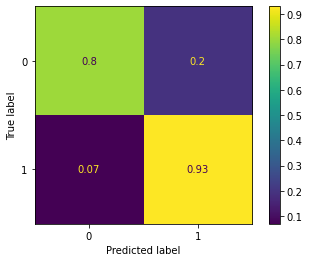

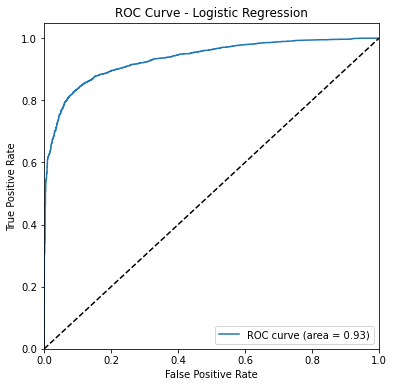

----------------------------------------
Métricas
----------------------------------------
Acurácia: 0.869135
Precisão: 0.834884
Recall: 0.930293
F1: 0.880010

Random Forest Classifier - Tuning
Dados de Teste
Matriz de Confusão
----------------------------------------


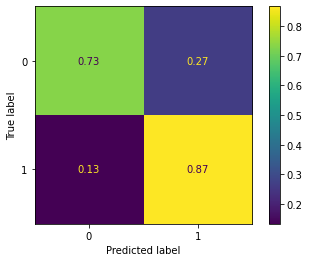

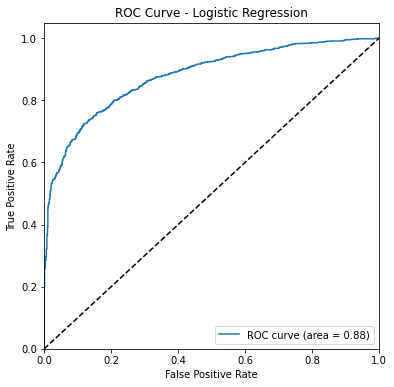

----------------------------------------
Métricas
----------------------------------------
Acurácia: 0.804242
Precisão: 0.785492
Recall: 0.867277
F1: 0.824361


In [39]:
print('Random Forest Classifier - Tuning')
print("="*40)
print("Dados de Treino")
print("="*40)
print("Matriz de Confusão")
print("-"*40)
calcula_mostra_matriz_confusao(previsoes_rfc_cv_treino, normalize='true')
print("-"*40)
print("Métricas")
print("-"*40)
print("Acurácia: %f" % evaluator.evaluate(previsoes_rfc_cv_treino, {evaluator.metricName: "accuracy"}))
print("Precisão: %f" % evaluator.evaluate(previsoes_rfc_cv_treino, {evaluator.metricName: "precisionByLabel", evaluator.metricLabel: 1}))
print("Recall: %f" % evaluator.evaluate(previsoes_rfc_cv_treino, {evaluator.metricName: "recallByLabel", evaluator.metricLabel: 1}))
print("F1: %f" % evaluator.evaluate(previsoes_rfc_cv_treino, {evaluator.metricName: "fMeasureByLabel", evaluator.metricLabel: 1}))
print("")
print("="*40)


print('Random Forest Classifier - Tuning')
print("="*40)
print("Dados de Teste")
print("="*40)
print("Matriz de Confusão")
print("-"*40)
calcula_mostra_matriz_confusao(previsoes_rfc_cv_teste, normalize='true')
print("-"*40)
print("Métricas")
print("-"*40)
print("Acurácia: %f" % evaluator.evaluate(previsoes_rfc_cv_teste, {evaluator.metricName: "accuracy"}))
print("Precisão: %f" % evaluator.evaluate(previsoes_rfc_cv_teste, {evaluator.metricName: "precisionByLabel", evaluator.metricLabel: 1}))
print("Recall: %f" % evaluator.evaluate(previsoes_rfc_cv_teste, {evaluator.metricName: "recallByLabel", evaluator.metricLabel: 1}))
print("F1: %f" % evaluator.evaluate(previsoes_rfc_cv_teste, {evaluator.metricName: "fMeasureByLabel", evaluator.metricLabel: 1}))

In [40]:
melhor_modelo_rfc_cv = modelo_rfc_cv.bestModel

print('Melhores parâmetros')
print('='*20)

print('Max Depth: ',melhor_modelo_rfc_cv.stages[-1].getMaxDepth())
print('Max Bins', melhor_modelo_rfc_cv.stages[-1].getMaxBins())
print('Trees: ',modelo_rfc_cv.bestModel.stages[-1].extractParamMap()[modelo_rfc_cv.bestModel.stages[-1].getParam('numTrees')])
print('Min Instances per node: ', melhor_modelo_rfc_cv.stages[-1].getMinInstancesPerNode())
print('Impurity: ', melhor_modelo_rfc_cv.stages[-1].getImpurity())
print('Bootstrap: ', melhor_modelo_rfc_cv.stages[-1].getBootstrap())
print('Feature Subset Strategy: ', melhor_modelo_rfc_cv.stages[-1].getFeatureSubsetStrategy())


Melhores parâmetros
Max Depth:  10
Max Bins 32
Trees:  100
Min Instances per node:  2
Impurity:  gini
Bootstrap:  True
Feature Subset Strategy:  auto


### Feature Importances

In [43]:
import pandas as pd
colunas = melhor_modelo_rfc_cv.stages[-2].getInputCols()
feat_importance = melhor_modelo_rfc_cv.stages[-1].featureImportances


df = round(pd.DataFrame (list(zip(colunas, feat_importance)), columns = ['coluna', 'importância (%)']).set_index('coluna')*100, 2)
df.sort_values(by = 'importância (%)', ascending=False)

,importância (%)
coluna,
tempo_permanencia_Scaled,13.11
mensalidade_Scaled,10.66
cobrancas_total_Scaled,8.80
contratoclassVec,8.27
seguranca_onlineclassVec,8.21
protecao_dispositivoclassVec,2.61
assinatura_tvclassVec,2.49
backup_onlineclassVec,1.69
fatura_digitalclassVec,1.63


In [73]:
np.logspace(-7,7,10,base=2)

array([7.81250000e-03, 2.29646014e-02, 6.75037337e-02, 1.98425131e-01,
       5.83264520e-01, 1.71448797e+00, 5.03968420e+00, 1.48139954e+01,
       4.35452800e+01, 1.28000000e+02])

# AVALIANDO O SCORE

In [57]:
previsoes_rfc_cv_teste.show()

+-----+-----+---------+-----+--------+-----------+-----------------+----------------+----------------+-------------+--------------------+---------------+-------------+-----------------+--------+--------------+--------------------+-----------+---------------+----------------------+------------------------+----------------+--------------------+--------------------+----------------------+-----------+--------------+---------------------+------------------------+------------------+---------------------+-------------------------+----------------------------+--------------------+-----------------------+------------------+---------------------+----------------------+-------------------------+-------------+----------------+-------------------+----------------------+---------------------+------------------------+--------------------+--------------------+--------------------+----------+
|index|label|   genero|idoso|parceirx|dependentes|tempo_permanencia|multiplas_linhas|seguranca_online|backup_on

In [58]:
teste_df = previsoes_rfc_cv_teste.toPandas()
teste_df

,index,label,genero,idoso,parceirx,dependentes,tempo_permanencia,multiplas_linhas,seguranca_online,backup_online,...,contratoIndex,contratoclassVec,fatura_digitalIndex,fatura_digitalclassVec,metodo_pagamentoIndex,metodo_pagamentoclassVec,features,rawPrediction,probability,prediction
0,6,0,Feminino,1,1,0,71,Não,Sim,Sim,...,1.0,"(0.0, 1.0)",0.0,(1.0),2.0,"(0.0, 0.0, 1.0)","(1.0, 1.0, 0.0, 2.966741803421551, 3.800551363...","[84.85628179649429, 15.143718203505703]","[0.848562817964943, 0.15143718203505704]",0.0
1,10,0,Masculino,0,0,0,54,Sem telefone,Sim,Não,...,1.0,"(0.0, 1.0)",1.0,(0.0),3.0,"(0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 2.256395174433292, 1.565951883...","[93.80339067186904, 6.196609328130935]","[0.9380339067186907, 0.06196609328130937]",0.0
2,11,0,Feminino,0,1,1,72,Sim,Sim,Sim,...,1.0,"(0.0, 1.0)",0.0,(1.0),3.0,"(0.0, 0.0, 0.0)","(0.0, 1.0, 1.0, 3.0085268992443894, 4.04653053...","[93.4249209001358, 6.5750790998641735]","[0.9342492090013583, 0.06575079099864176]",0.0
3,12,0,Feminino,0,1,0,5,Não,Não,Não,...,0.0,"(1.0, 0.0)",0.0,(1.0),0.0,"(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.2089254791141937, 2.38876952...","[19.45667888506533, 80.54332111493467]","[0.1945667888506533, 0.8054332111493467]",1.0
4,20,0,Feminino,1,1,0,50,Sim,Sem internet,Sem internet,...,2.0,"(0.0, 0.0)",1.0,(0.0),0.0,"(1.0, 0.0, 0.0)","(1.0, 1.0, 0.0, 2.0892547911419372, 0.87305282...","[92.39271206176554, 7.607287938234475]","[0.9239271206176553, 0.07607287938234475]",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,7243,1,Masculino,1,0,0,21,Não,Não,Não,...,0.0,"(1.0, 0.0)",0.0,(1.0),2.0,"(0.0, 0.0, 1.0)","(1.0, 0.0, 0.0, 0.8774870122796136, 3.35363146...","[21.979179698947757, 78.02082030105225]","[0.21979179698947754, 0.7802082030105224]",1.0
3296,7261,1,Feminino,0,0,0,4,Não,Sem internet,Sem internet,...,0.0,"(1.0, 0.0)",1.0,(0.0),2.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.16714038329135497, 0.7258117...","[70.61498600579444, 29.385013994205543]","[0.7061498600579446, 0.2938501399420555]",0.0
3297,7261,1,Feminino,0,0,0,4,Não,Sem internet,Sem internet,...,0.0,"(1.0, 0.0)",1.0,(0.0),2.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.16714038329135497, 0.7258117...","[70.61498600579444, 29.385013994205543]","[0.7061498600579446, 0.2938501399420555]",0.0
3298,7261,1,Feminino,0,0,0,4,Não,Sem internet,Sem internet,...,0.0,"(1.0, 0.0)",1.0,(0.0),2.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.16714038329135497, 0.7258117...","[70.61498600579444, 29.385013994205543]","[0.7061498600579446, 0.2938501399420555]",0.0


In [63]:
y_score = [i[1] for i in teste_df.probability]
y_score

[0.15143718203505704,
 0.06196609328130937,
 0.06575079099864176,
 0.8054332111493467,
 0.07607287938234475,
 0.7780057835122325,
 0.35755949370232226,
 0.2631450229081075,
 0.022386130457815893,
 0.08171857217806881,
 0.37796837780756326,
 0.2117553779559894,
 0.8431382271091653,
 0.6969491651636027,
 0.6292813122311837,
 0.7503371658775997,
 0.6614062788495261,
 0.6773795654948309,
 0.028354100682251242,
 0.25196756943383924,
 0.6794328518513822,
 0.48475518305427573,
 0.2525807704641592,
 0.07210069063437785,
 0.8167655076474452,
 0.021387974555899764,
 0.5791699627938278,
 0.5169056341084569,
 0.3492395345223946,
 0.4368990687059807,
 0.33128898355758163,
 0.11486748972578184,
 0.18771289921074968,
 0.07210069063437785,
 0.15898734032453707,
 0.7217286053159352,
 0.02991139608384782,
 0.6958853080905815,
 0.02040412583822564,
 0.2552981765042389,
 0.3578176004093229,
 0.026004951244830214,
 0.19776887832084633,
 0.2954538319134794,
 0.49500839597381197,
 0.3634313096746296,
 0.6665

In [64]:
teste_df['score'] = y_score
teste_df

,index,label,genero,idoso,parceirx,dependentes,tempo_permanencia,multiplas_linhas,seguranca_online,backup_online,...,contratoclassVec,fatura_digitalIndex,fatura_digitalclassVec,metodo_pagamentoIndex,metodo_pagamentoclassVec,features,rawPrediction,probability,prediction,score
0,6,0,Feminino,1,1,0,71,Não,Sim,Sim,...,"(0.0, 1.0)",0.0,(1.0),2.0,"(0.0, 0.0, 1.0)","(1.0, 1.0, 0.0, 2.966741803421551, 3.800551363...","[84.85628179649429, 15.143718203505703]","[0.848562817964943, 0.15143718203505704]",0.0,0.151437
1,10,0,Masculino,0,0,0,54,Sem telefone,Sim,Não,...,"(0.0, 1.0)",1.0,(0.0),3.0,"(0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 2.256395174433292, 1.565951883...","[93.80339067186904, 6.196609328130935]","[0.9380339067186907, 0.06196609328130937]",0.0,0.061966
2,11,0,Feminino,0,1,1,72,Sim,Sim,Sim,...,"(0.0, 1.0)",0.0,(1.0),3.0,"(0.0, 0.0, 0.0)","(0.0, 1.0, 1.0, 3.0085268992443894, 4.04653053...","[93.4249209001358, 6.5750790998641735]","[0.9342492090013583, 0.06575079099864176]",0.0,0.065751
3,12,0,Feminino,0,1,0,5,Não,Não,Não,...,"(1.0, 0.0)",0.0,(1.0),0.0,"(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.2089254791141937, 2.38876952...","[19.45667888506533, 80.54332111493467]","[0.1945667888506533, 0.8054332111493467]",1.0,0.805433
4,20,0,Feminino,1,1,0,50,Sim,Sem internet,Sem internet,...,"(0.0, 0.0)",1.0,(0.0),0.0,"(1.0, 0.0, 0.0)","(1.0, 1.0, 0.0, 2.0892547911419372, 0.87305282...","[92.39271206176554, 7.607287938234475]","[0.9239271206176553, 0.07607287938234475]",0.0,0.076073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,7243,1,Masculino,1,0,0,21,Não,Não,Não,...,"(1.0, 0.0)",0.0,(1.0),2.0,"(0.0, 0.0, 1.0)","(1.0, 0.0, 0.0, 0.8774870122796136, 3.35363146...","[21.979179698947757, 78.02082030105225]","[0.21979179698947754, 0.7802082030105224]",1.0,0.780208
3296,7261,1,Feminino,0,0,0,4,Não,Sem internet,Sem internet,...,"(1.0, 0.0)",1.0,(0.0),2.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.16714038329135497, 0.7258117...","[70.61498600579444, 29.385013994205543]","[0.7061498600579446, 0.2938501399420555]",0.0,0.293850
3297,7261,1,Feminino,0,0,0,4,Não,Sem internet,Sem internet,...,"(1.0, 0.0)",1.0,(0.0),2.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.16714038329135497, 0.7258117...","[70.61498600579444, 29.385013994205543]","[0.7061498600579446, 0.2938501399420555]",0.0,0.293850
3298,7261,1,Feminino,0,0,0,4,Não,Sem internet,Sem internet,...,"(1.0, 0.0)",1.0,(0.0),2.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.16714038329135497, 0.7258117...","[70.61498600579444, 29.385013994205543]","[0.7061498600579446, 0.2938501399420555]",0.0,0.293850


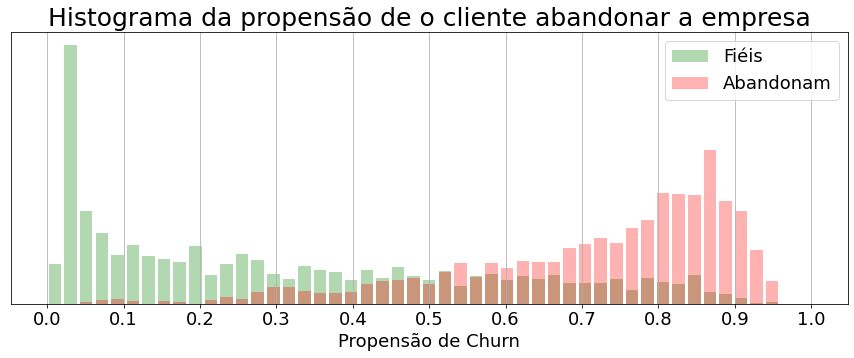

In [71]:
pred_churn = teste_df.loc[teste_df.label == 1, 'score']
pred_continua = teste_df.loc[teste_df.label == 0, 'score']

plt.figure(figsize=(15,5))
plt.hist(pred_continua, bins=np.linspace(0,1,50), density=True, color='g', alpha=.3, rwidth=.8, label='Fiéis')
plt.hist(pred_churn, bins=np.linspace(0,1,50), density=True, color='r', alpha=.3, rwidth=.8, label='Abandonam');

plt.xticks(np.arange(0,1.001,0.10), fontsize=18);
plt.yticks([])
plt.legend(fontsize=18)
plt.title('Histograma da propensão de o cliente abandonar a empresa', size = 25)
plt.xlabel('Propensão de Churn', fontsize=18)
plt.grid()

# Buscando o melhor threshold

In [94]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

def testing_best_threshold(df): # melhor threshold de acordo com o F1
    testy = df['label']
    yhat = df['score']
    # calculate roc curves
    precision, recall, thresholds = precision_recall_curve(testy, yhat)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    
    # plot the roc curve for the model
    plt.figure(figsize=(12,5))

    plt.plot(thresholds, fscore[1:], label='modelo', linewidth=2)
    print(thresholds, len(thresholds))
    plt.scatter(thresholds[ix], fscore[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('Threshold')
    plt.ylabel('F1')
    plt.legend()
    # show the plot
    plt.show()

Best Threshold=0.422036, F-Score=0.831
[0.04742516 0.04751337 0.04755652 ... 0.94187598 0.94321198 0.94356705] 2414


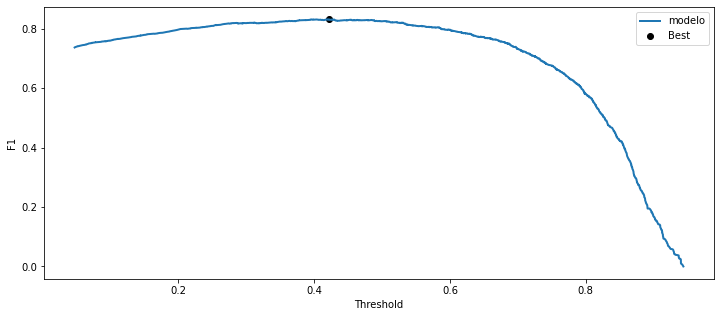

In [95]:
testing_best_threshold(teste_df)

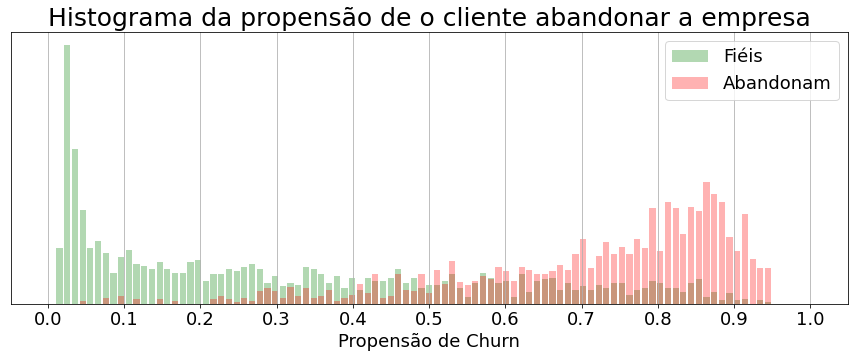

In [81]:
pred_churn = teste_df.loc[teste_df.label == 1, 'score']
pred_continua = teste_df.loc[teste_df.label == 0, 'score']

plt.figure(figsize=(15,5))
plt.hist(pred_continua, bins=np.linspace(0,1,100), density=True, color='g', alpha=.3, rwidth=.8, label='Fiéis')
plt.hist(pred_churn, bins=np.linspace(0,1,100), density=True, color='r', alpha=.3, rwidth=.8, label='Abandonam');

plt.xticks(np.arange(0,1.001,0.10), fontsize=18);
plt.yticks([])
plt.legend(fontsize=18)
plt.title('Histograma da propensão de o cliente abandonar a empresa', size = 25)
plt.xlabel('Propensão de Churn', fontsize=18)
plt.grid()